In [2]:
import pandas as pd
global_temp = pd.read_csv(r"C:\Users\Methilesh K\Downloads\GlobalTemperatures.csv")
print(global_temp.shape)
print(global_temp.columns)
print(global_temp.info())
print(global_temp.isnull().sum())

(3192, 9)
Index(['dt', 'LandAverageTemperature', 'LandAverageTemperatureUncertainty',
       'LandMaxTemperature', 'LandMaxTemperatureUncertainty',
       'LandMinTemperature', 'LandMinTemperatureUncertainty',
       'LandAndOceanAverageTemperature',
       'LandAndOceanAverageTemperatureUncertainty'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3192 entries, 0 to 3191
Data columns (total 9 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   dt                                         3192 non-null   object 
 1   LandAverageTemperature                     3180 non-null   float64
 2   LandAverageTemperatureUncertainty          3180 non-null   float64
 3   LandMaxTemperature                         1992 non-null   float64
 4   LandMaxTemperatureUncertainty              1992 non-null   float64
 5   LandMinTemperature                         1992 non-null   

# Data Preparation

In [6]:
def wrangle(df):
    df = df.copy()
    df = df.drop(columns=["LandAverageTemperatureUncertainty", "LandMaxTemperatureUncertainty",
                          "LandMinTemperatureUncertainty", "LandAndOceanAverageTemperatureUncertainty"], axis=1)

In [12]:
def wrangle(df):
    def converttemp(x):
        x = (x * 1.8) + 32
        return float(x)

    df["LandAverageTemperature"] = df["LandAverageTemperature"].apply(converttemp)
    df["LandMaxTemperature"] = df["LandMaxTemperature"].apply(converttemp)
    df["LandMinTemperature"] = df["LandMinTemperature"].apply(converttemp)
    df["LandAndOceanAverageTemperature"] = df["LandAndOceanAverageTemperature"].apply(converttemp)
    df["dt"] = pd.to_datetime(df["dt"])
    df["Month"] = df["dt"].dt.month
    df["Year"] = df["dt"].dt.year
    df = df.drop("dt", axis=1)
    df = df.drop("Month", axis=1)
    df = df[df.Year >= 1850]
    df = df.set_index(["Year"])
    df = df.dropna()
    return df

global_temp = wrangle(global_temp)
print(global_temp.head())


      LandAverageTemperature  LandAverageTemperatureUncertainty  \
Year                                                              
1850                 33.3482                              1.105   
1850                 37.5278                              1.275   
1850                 40.9172                              0.955   
1850                 44.9906                              0.665   
1850                 50.0072                              0.617   

      LandMaxTemperature  LandMaxTemperatureUncertainty  LandMinTemperature  \
Year                                                                          
1850             46.8356                          1.738             26.2292   
1850             49.9460                          3.007             27.8762   
1850             50.6246                          2.401             28.5710   
1850             55.2812                          1.004             33.8324   
1850             60.1790                          2.406 

# Visualization

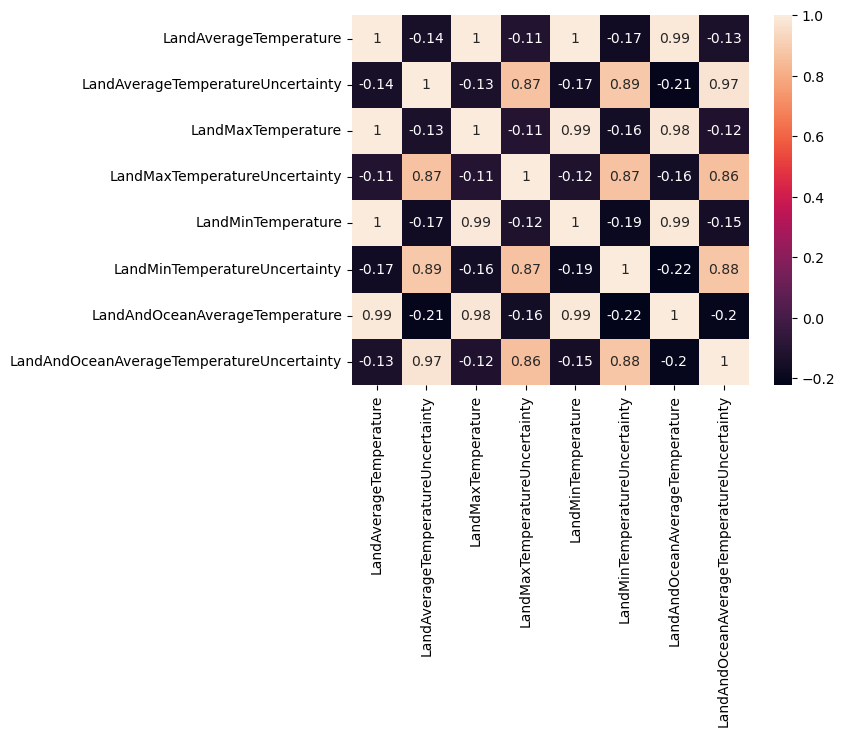

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
corrMatrix = global_temp.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [14]:
target = "LandAndOceanAverageTemperature"
y = global_temp[target]
x = global_temp[["LandAverageTemperature", "LandMaxTemperature", "LandMinTemperature"]]

# Train Test Split

In [15]:
from sklearn.model_selection import train_test_split
xtrain, xval, ytrain, yval = train_test_split(x, y, test_size=0.25, random_state=42)
print(xtrain.shape)
print(xval.shape)
print(ytrain.shape)
print(yval.shape)

(1494, 3)
(498, 3)
(1494,)
(498,)


In [16]:
from sklearn.metrics import mean_squared_error
ypred = [ytrain.mean()] * len(ytrain)
print("Baseline MAE: ", round(mean_squared_error(ytrain, ypred), 5))

Baseline MAE:  5.29374


In [18]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

forest = make_pipeline(
    SelectKBest(k="all"),
    StandardScaler(),
    RandomForestRegressor(
        n_estimators=100,
        max_depth=50,
        random_state=77,
        n_jobs=-1
    )
)
forest.fit(xtrain, ytrain)


Pipeline(steps=[('selectkbest', SelectKBest(k='all')),
                ('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=50, n_jobs=-1,
                                       random_state=77))])

In [22]:
import numpy as np

# Assuming both ypred and yval are Series or numpy arrays
if len(ypred) != len(yval):
    # Handle the mismatch, such as truncating or padding one of the arrays
    min_length = min(len(ypred), len(yval))
    ypred = ypred[:min_length]
    yval = yval[:min_length]

# Now perform the arithmetic operation
errors = abs(ypred - yval)
mape = 100 * (errors/ytrain)
accuracy = 100 - np.mean(mape)
print("Random Forest Model: ", round(accuracy, 2), "%")


Random Forest Model:  96.61 %
